### Bootstrap Confidence Intervals

Bootstrap methods, introduced by Efron in 1979, have become a powerful tool for statistical inference, providing a non-parametric approach to estimating the sampling distribution of a statistic. The following elucidates the theoretical underpinnings of the provided code, emphasizing each step in an academic style.

#### 1. Resampling (Bootstrap Samples):

Given an observed dataset $D$ with $n$ observations, the goal is to simulate new datasets, referred to as bootstrap samples, by resampling with replacement. This process aims to mimic the randomness inherent in the sampling process. For $n_{\text{resamples}}$ iterations, a bootstrap sample $D_i$ is generated:

$$ D_i = \{D_{i1}, D_{i2}, \ldots, D_{in}\} $$

#### 2. Bootstrap Confidence Intervals:

The `ci_bootstrap` function is designed to construct confidence intervals for a specified statistic using the generated bootstrap samples. The procedure unfolds as follows:


##### 2.1 Resampling:

Utilizing the `resample` function, the original dataset $D$ is subjected to the bootstrap resampling process. $n_{\text{resamples}}$ bootstrap samples are generated, introducing variability through the resampling procedure.

$$ \text{Bootstrap Sample}_i = \{D_{i1}, D_{i2}, \ldots, D_{in}\} $$

##### 2.2 Statistic Computation:

For each bootstrap sample, the chosen statistic (denoted as $\theta$) is computed. This step yields a distribution of the statistic across the bootstrap samples, providing insights into its variability.

$$ \theta_i = \text{statistic}(D_i) $$

##### 2.3 Interval Types:

The code supports different interval types, each addressing specific aspects of the bootstrap distribution:

- **Percentile Interval (`type='percentile'`):**
  - Computes lower and upper bounds based on percentiles of the bootstrap distribution.

- **Empirical Interval (`type='empirical'`):**
  - Utilizes the empirical distribution of the differences between the statistic in each resampled dataset and the original dataset.

- **t-Distribution Interval (`type='t-distribution'`):**
  - Assumes the distribution of the statistic follows a t-distribution and computes bounds using t-distribution critical values.

##### Formulas for Confidence Intervals:

1. **Percentile Interval:**
   $$ [\text{Percentile}_{\alpha/2}, \text{Percentile}_{1-\alpha/2}] $$

2. **Empirical Interval:**
   $$ [\hat{\theta} - \text{Percentile}_{1-\alpha/2}(\text{Differences}), \hat{\theta} - \text{Percentile}_{\alpha/2}(\text{Differences})] $$

3. **t-Distribution Interval:**
   $$ [\hat{\theta} - \text{Critical Value} \times \text{Standard Error}, \hat{\theta} + \text{Critical Value} \times \text{Standard Error}] $$


In [77]:
import numpy as np 
from scipy import stats
import pandas as pd 
import matplotlib.pyplot as plt

In [51]:
data = pd.read_csv('data/verizon.txt', sep='\t')
data.Group.value_counts()

ILEC    1664
CLEC      23
Name: Group, dtype: int64

In [74]:
def resample(data, n_resamples):
    n = len(data)
    idx = np.random.randint(low=0, high=n, size=(n_resamples, n))
    resampled = data[idx]
    return resampled

def ci_bootstrap(data, statistic, alpha, n_resamples=1000, type='percentile'):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    n = data.shape[-1]
    resampled_data = resample(data=data, n_resamples=n_resamples)
    resampled_data  = np.array(resampled_data )

    stat_values = [statistic(resampled_row) for resampled_row in resampled_data]
    if type == 'percentile':
        bound_lower, bound_upper = np.percentile(stat_values, [100*alpha/2, 100*(1-alpha/2)])
    elif type == 'empirical':
        x_hat = statistic(data)
        d = stat_values - x_hat
        d_lower, d_upper = np.percentile(d, [100*alpha/2, 100*(1-alpha/2)])
        bound_lower, bound_upper = x_hat - d_upper, x_hat - d_lower
    elif type == 't-distribution':
        x_hat = statistic(data)
        se_boot = np.std(stat_values, ddof=1)
        df = n - 1
        z_crit = abs(stats.t.ppf(alpha/2, df=df))
        bound_lower, bound_upper = x_hat - z_crit*se_boot, x_hat + z_crit*se_boot
    else:
        raise KeyError('This type of CI is not implemented.')
    return bound_lower, bound_upper


def ci_bootstrap_two_samples(data_1, data_2, statistic, alpha, n_resamples=1000, type='percentile'):
    if not isinstance(data_1, np.ndarray):
        data_1 = np.array(data_1)
    if not isinstance(data_2, np.ndarray):
        data_2 = np.array(data_2)
    resampled_data_1 = resample(data=data_1, n_resamples=n_resamples)
    resampled_data_1  = np.array(resampled_data_1)
    resampled_data_2 = resample(data=data_2, n_resamples=n_resamples)
    resampled_data_2  = np.array(resampled_data_2)

    stat_values = [statistic(resampled_row) for resampled_row in zip(resampled_data_1, resampled_data_2)]
    if type == 'percentile':
        bound_lower, bound_upper = np.percentile(stat_values, [100*alpha/2, 100*(1-alpha/2)])
    elif type == 'empirical':
        x_hat = statistic((data_1, data_2))
        d = stat_values - x_hat
        d_lower, d_upper = np.percentile(d, [100*alpha/2, 100*(1-alpha/2)])
        bound_lower, bound_upper = x_hat - d_upper, x_hat - d_lower
    else:
        raise KeyError('This type of CI is not implemented.')
    return bound_lower, bound_upper

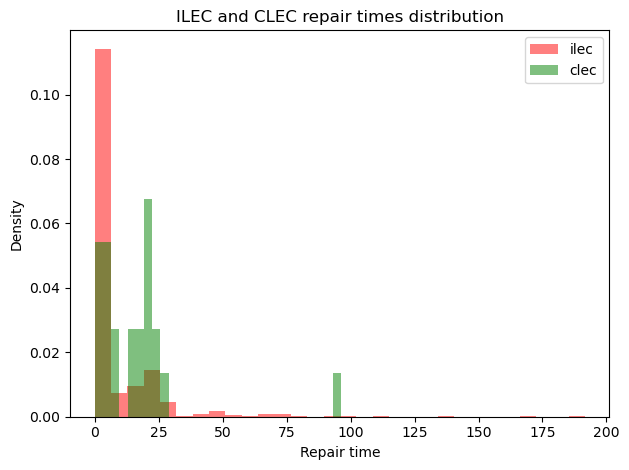

In [134]:
ilec = data[data['Group'] == 'ILEC']['Time'].values
clec = data[data['Group'] == 'CLEC']['Time'].values

plt.hist(ilec, bins=30, color='r', density=True, alpha=0.5, label='ilec')
plt.hist(clec, bins=30, color='g', density=True, alpha=0.5, label='clec')
plt.title('ILEC and CLEC repair times distribution')
plt.ylabel('Density')
plt.xlabel('Repair time')
plt.legend()
plt.tight_layout()


In [117]:
ilec_ci = ci_bootstrap(ilec, np.median, 0.05, n_resamples=5000, type='empirical')
clec_ci = ci_bootstrap(clec, np.median, 0.05, n_resamples=5000, type='empirical')

print(f"Bootstrap CI for ILEC Median: {ilec_ci[0]:2.3f} to {ilec_ci[1]:2.3f}")
print(f"Bootstrap CI for CLEC Median: {clec_ci[0]:2.3f} to {clec_ci[1]:2.3f}")



Bootstrap CI for ILEC Median: 3.350 to 3.960
Bootstrap CI for CLEC Median: 8.380 to 22.860


In [112]:
n_resamples = 5000
alpha = 0.05
ilec_resample = resample(ilec, n_resamples)
clec_resample = resample(clec, n_resamples)

statistic = lambda x: np.median(x[0]) - np.median(x[1])
median_diff = np.array(list(map(statistic, zip(ilec_resample, clec_resample))))

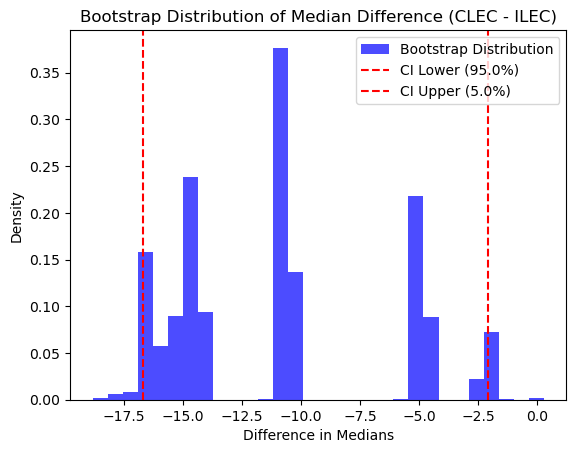

In [133]:
ci_lower, ci_upper = ci_bootstrap_two_samples(ilec, clec, statistic, alpha, n_resamples)

plt.hist(median_diff, bins=30, density=True, alpha=0.7, color='blue', label='Bootstrap Distribution')
plt.axvline(ci_lower, color='red', linestyle='--', label=f'CI Lower ({100*(1-alpha):.1f}%)')
plt.axvline(ci_upper, color='red', linestyle='--', label=f'CI Upper ({100*alpha:.1f}%)')

plt.title('Bootstrap Distribution of Median Difference (CLEC - ILEC)')
plt.xlabel('Difference in Medians')
plt.ylabel('Density')
plt.legend()
plt.show()

In [120]:
med_diff_ci_emp = ci_bootstrap_two_samples(ilec, clec, statistic, 0.05, n_resamples=1000, type='empirical')
med_diff_ci_per = ci_bootstrap_two_samples(ilec, clec, statistic, 0.05, n_resamples=1000, type='percentile')

print(f"Empirical Bootstrap CI for Median Differences: {med_diff_ci_emp[0]:2.3f} to {med_diff_ci_emp[1]:2.3f}")
print(f"Percentile Bootstrap CI for Median Differences: {med_diff_ci_per[0]:2.3f} to {med_diff_ci_per[1]:2.3f}")

Empirical Bootstrap CI for Median Differences: -19.410 to -4.810
Percentile Bootstrap CI for Median Differences: -16.675 to -1.999


### BCa Bootstrap Confidence Intervals

**1. Percentile Confidence Interval:**
The traditional percentile bootstrap confidence interval is given by:

$$ [Q(\alpha/2), Q(1-\alpha/2)] $$

where $ Q(p) $ is the $p$-th percentile of the bootstrap distribution.

**2. BCa Intervals Components:**
   - **Bias Correction (B):**
     $$ B = Q_\theta - \hat{\theta} $$
     where $ Q_\theta $ is the bootstrap estimate of the true parameter $ \theta $ and $ \hat{\theta} $ is the original estimate.

   - **Acceleration (a):**
     $$ a = \frac{1}{6} \frac{\sum (Q_\theta - \bar{Q})^3}{\left(\sum (Q_\theta - \bar{Q})^2\right)^{3/2}} $$
     where $ \bar{Q} $ is the average of the bootstrap estimates.

**3. Bias-Corrected Estimate:**
   $$ \tilde{Q}_\theta = Q_\theta - B $$

**4. Accelerated Estimate:**
   $$ z_0 = \frac{\tilde{Q}_\theta - \hat{\theta}}{SE_{\text{boot}}} $$
   where $ SE_{\text{boot}} $ is the standard error of the bootstrap estimates.

**5. Confidence Interval Indices:**
   $$ \alpha_1 = \Phi(z_0 + (z_0 + z_{\alpha/2})/(1 - a(z_0 + z_{\alpha/2}))) $$
   $$ \alpha_2 = \Phi(z_0 + (z_0 + z_{1-\alpha/2})/(1 - a(z_0 + z_{1-\alpha/2}))) $$
   where $ \Phi $ is the cumulative distribution function of the standard normal distribution.

**6. BCa Confidence Interval:**
   $$ [\tilde{Q}_{(\alpha_1)}, \tilde{Q}_{(\alpha_2)}] $$



In [43]:
import numpy as np
import scipy.stats as st

# Adopted from:
# http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2019a/content/recitations/bootstrapping.html
#

def compute_jackknife_reps(data, statfunction=np.mean):
    '''Returns jackknife resampled replicates for the given data and statistical function'''
    return np.array([statfunction(np.delete(data, i)) for i in range(len(data))])

def compute_a(jack_reps):
    '''Returns the acceleration constant a'''
    return (1/6) * np.sum((np.mean(jack_reps) - jack_reps)**3) / np.sum((np.mean(jack_reps) - jack_reps)**2)**(3/2)

def bootstrap_replicates(data, n_reps=1000, statfunction=np.mean):
    '''Computes n_reps number of bootstrap replicates for given data and statistical function'''
    return np.array([statfunction(np.random.choice(data, size=len(data))) for _ in range(n_reps)])

def compute_z0(data, boot_reps, statfunction=np.mean):
    '''Computes z0 for given data and statistical function'''
    s = statfunction(data)
    return st.norm.ppf(np.sum(boot_reps < s) / len(boot_reps))

def compute_bca_ci(data, alpha_level, n_reps=1000, statfunction=np.mean):
    '''Returns BCa confidence interval for given data at given alpha level'''
    boot_reps = bootstrap_replicates(data, n_reps, statfunction)
    jack_reps = compute_jackknife_reps(data, statfunction)

    a = compute_a(jack_reps)
    z0 = compute_z0(data, boot_reps, statfunction)

    alphas = np.array([alpha_level/2., 1-alpha_level/2.])
    zs = z0 + st.norm.ppf(alphas).reshape(alphas.shape+(1,)*z0.ndim)
    avals = st.norm.cdf(z0 + zs/(1-a*zs))
    ints = np.round((len(boot_reps)-1) * avals).astype('int')

    boot_reps = np.sort(boot_reps)
    return boot_reps[ints[0]], boot_reps[ints[1]]


In [129]:
df_worms = pd.read_csv('data/c_elegans_egg_xa.csv', comment='#')
fed_worms = df_worms.loc[df_worms['food'] == 'high']['area (sq. um)'].values
hungry_worms = df_worms.loc[df_worms['food'] == 'low']['area (sq. um)'].values

In [132]:
ci_fed = compute_bca_ci(fed_worms, 0.05)
ci_hungry = compute_bca_ci(hungry_worms, 0.05)
print(f'Fed worms mean egg area 95% C.I.: {ci_fed[0]:3.2f} {ci_fed[1]:3.2f}')
print(f'Hungry worms mean egg area 95% C.I.: {ci_hungry[0]:3.2f} {ci_hungry[1]:3.2f}')


Fed worms mean egg area 95% C.I.: 1782.27 1857.36
Hungry worms mean egg area 95% C.I.: 2056.56 2136.95
